In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
from collections import defaultdict
from scipy.io import mmread
from scipy.sparse import csr_matrix
import pickle as pkl
import seaborn as sns

from sklearn.metrics.pairwise import euclidean_distances
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

import gc

from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sb
#import seaborn as sns

import scib_metrics as sm
import sys
import os
sys.path.append('/'.join(os.getcwd().split('/')[:-1]+['eval','cleaned','']))
#from metrics import ilisi,asw_batch

%load_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', None)

# Define the path to the directory you want to change to
new_directory = '/scratch365/eaboelno/cVAE_analysis/'

# Use os.chdir() to change the working directory
os.chdir(new_directory)

# Set up data for integrations- HVG

In [97]:
adata = sc.read_h5ad('./sysVI/Adams_CC_resetX_BACKUP.h5ad')
adata

AnnData object with n_obs × n_vars = 21541 × 19107
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'mouse_gene_id', 'n_cells', 'mouse_gene_name', 'human_gene_name', 'human_gene_id'
    layers: 'counts'

In [98]:
print(adata.X[:5, :5])

  (0, 2)	1
  (1, 4)	5
  (2, 4)	1
  (3, 4)	3
  (4, 4)	3


In [99]:
adata.raw = adata

In [100]:
print(adata.raw.X[:5, :5])

  (0, 2)	1
  (1, 4)	5
  (2, 4)	1
  (3, 4)	3
  (4, 4)	3


In [102]:
min_total_counts = adata.obs['total_counts'].min()
max_total_counts = adata.obs['total_counts'].max()

print("Minimum total counts:", min_total_counts)
print("Maximum total counts:", max_total_counts)

Minimum total counts: 500.0
Maximum total counts: 36954.0


In [103]:
min_total_counts = adata.obs['n_genes_by_counts'].min()
max_total_counts = adata.obs['n_genes_by_counts'].max()

print("Minimum n_genes_by_counts:", min_total_counts)
print("Maximum n_genes_by_counts:", max_total_counts)

Minimum n_genes_by_counts: 204.0
Maximum n_genes_by_counts: 7038.0


In [104]:
# Count the number of cells with total counts higher than 50,000
num_cells_above_50000 = (adata.obs['total_counts'] > 15000).sum()

print("Number of cells with total counts higher than 15,000:", num_cells_above_50000)


Number of cells with total counts higher than 15,000: 158


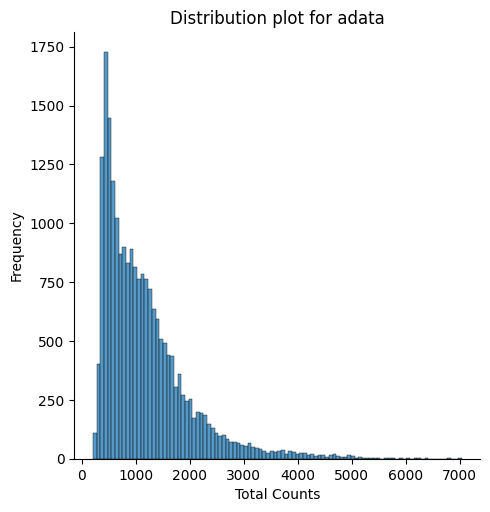

In [105]:
# Create a distribution plot for 'total_counts' column in the current AnnData frame
p = sns.displot(adata.obs["n_genes_by_counts"], bins=100, kde=False)
plt.title(f"Distribution plot for adata")  # Set plot title
plt.xlabel("Total Counts")  # Set x-axis label
plt.ylabel("Frequency")  # Set y-axis label
plt.show()  # Show the plot

In [107]:
adata_filt = adata[adata.obs['total_counts'] < 15000]
adata_filt

View of AnnData object with n_obs × n_vars = 21383 × 19107
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'mouse_gene_id', 'n_cells', 'mouse_gene_name', 'human_gene_name', 'human_gene_id'
    layers: 'counts'

In [108]:
adata_filt = adata_filt[adata_filt.obs['n_genes_by_counts'] < 7000]
adata_filt

View of AnnData object with n_obs × n_vars = 21383 × 19107
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'mouse_gene_id', 'n_cells', 'mouse_gene_name', 'human_gene_name', 'human_gene_id'
    layers: 'counts'

In [109]:
sc.pp.filter_genes(adata_filt, min_cells=10)
adata_filt

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:250: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


AnnData object with n_obs × n_vars = 21383 × 19107
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'mouse_gene_id', 'n_cells', 'mouse_gene_name', 'human_gene_name', 'human_gene_id'
    layers: 'counts'

In [110]:
adata_filt=adata_filt[:,np.array((adata_filt.X>0).sum(axis=0)>20).ravel()]
adata_filt

View of AnnData object with n_obs × n_vars = 21383 × 18956
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'mouse_gene_id', 'n_cells', 'mouse_gene_name', 'human_gene_name', 'human_gene_id'
    layers: 'counts'

In [111]:
print(adata_filt.X[:5, :5])

  (0, 4)	1
  (3, 2)	1
  (3, 4)	2
  (4, 4)	1


In [112]:
sc.pp.normalize_total(adata_filt, target_sum=1e4)
adata_filt.layers["log1p_norm"] = sc.pp.log1p(adata_filt.X)

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [113]:
print(adata_filt.X[:5, :5])

  (0, 4)	0.51401925
  (3, 2)	0.52225447
  (3, 4)	0.8635851
  (4, 4)	0.53151506


In [114]:
min_total_counts = adata_filt.obs['total_counts'].min()
max_total_counts = adata_filt.obs['total_counts'].max()

print("Minimum total counts:", min_total_counts)
print("Maximum total counts:", max_total_counts)

Minimum total counts: 500.0
Maximum total counts: 14995.0


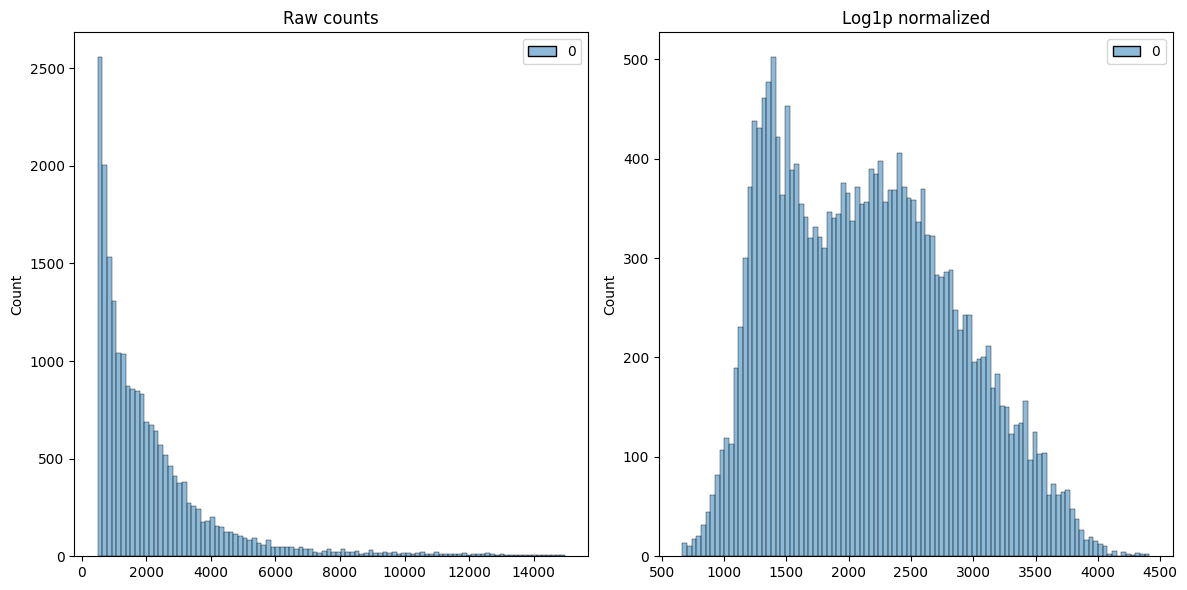

In [115]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot total counts
sns.histplot(adata_filt.layers["counts"].sum(1), bins=100, kde=False, ax=axes[0])
axes[0].set_title("Raw counts")

# Plot shifted logarithm
sns.histplot(adata_filt.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Log1p normalized")

plt.tight_layout()
plt.show()

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


<Axes: ylabel='value'>

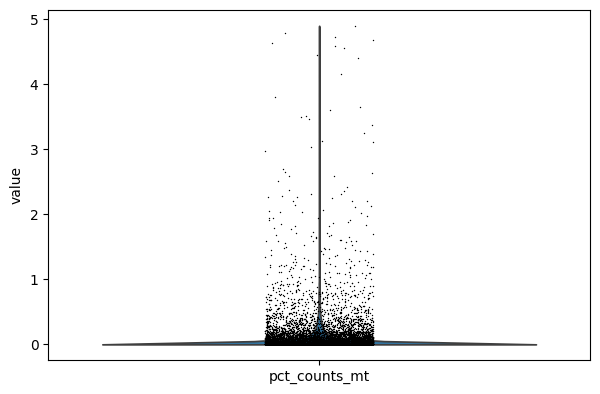

In [138]:
sc.pl.violin(adata_filt, keys="pct_counts_mt", show=False)

In [116]:
adata_filt.write_h5ad('./sysVI/Adams_QC_resetX_TRIMMED_BACKUP.h5ad')

# Redo mdata with seurat_v3-- Check value QCs

In [29]:
mdata = sc.read_h5ad('./human_mouse/mdata_m2h_simplified_labeled.h5ad')
mdata

AnnData object with n_obs × n_vars = 335694 × 30936
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 's_score', 'g2m_score', 'phase', 'cell_cycle_diff', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'pct_counts_ribo', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'human_gene_id', 'n_cells', 'mouse_gene_id', 'mouse_gene_name', 'human_gene_name'
    layers: 'counts', 'log1p_norm'

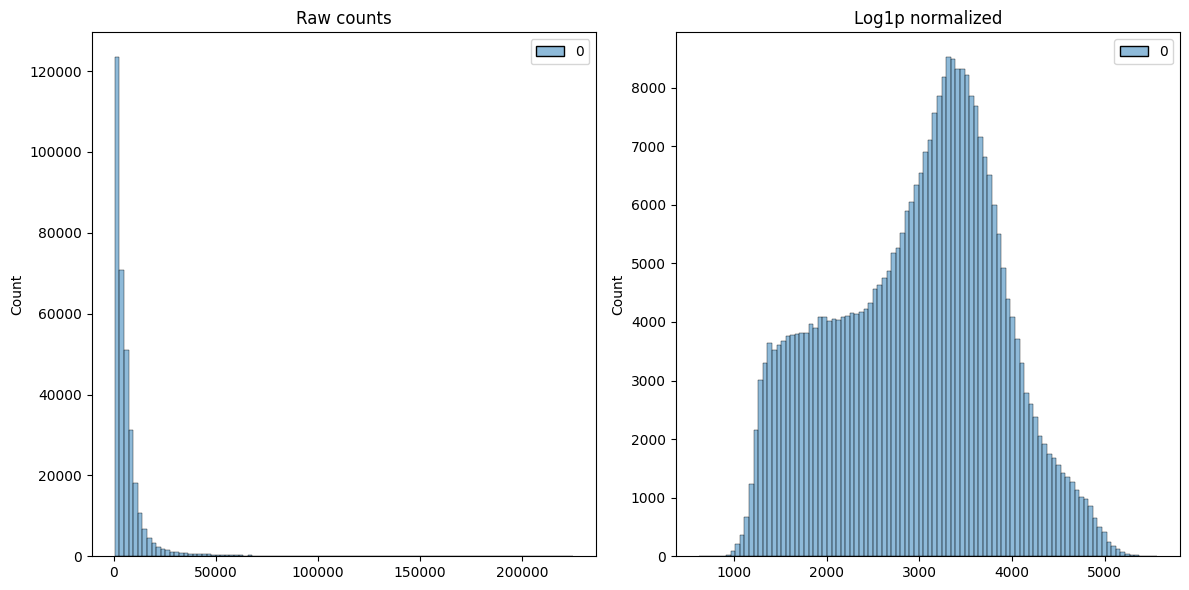

In [30]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot total counts
sns.histplot(mdata.layers["counts"].sum(1), bins=100, kde=False, ax=axes[0])
axes[0].set_title("Raw counts")

# Plot shifted logarithm
sns.histplot(mdata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Log1p normalized")

plt.tight_layout()
plt.show()

In [32]:
mdata.X = mdata.layers['counts']
#del mdata.layers["log1p_norm"]
del mdata.raw

In [38]:
sc.pp.calculate_qc_metrics(mdata, percent_top=None, log1p=False, inplace=True)

In [40]:
# Find the minimum and maximum values in mdata.X
min_value = mdata.X.min()
max_value = mdata.X.max()

print("Minimum value:", min_value)
print("Maximum value:", max_value)

Minimum value: 0.0
Maximum value: 12237.0


In [41]:
min_total_counts = mdata.obs['total_counts'].min()
max_total_counts = mdata.obs['total_counts'].max()

print("Minimum total counts:", min_total_counts)
print("Maximum total counts:", max_total_counts)

Minimum total counts: 497.0
Maximum total counts: 225280.0


In [69]:
num_cells_less_500 = (mdata.obs['total_counts'] < 500).sum()

print("Number of cells with total counts less than 500:", num_cells_less_500)

Number of cells with total counts less than 500: 1


In [47]:
num_cells_above_50000 = (mdata.obs['total_counts'] > 50000).sum()

print("Number of cells with total counts higher than 50,000:", num_cells_above_50000)


Number of cells with total counts higher than 50,000: 3622


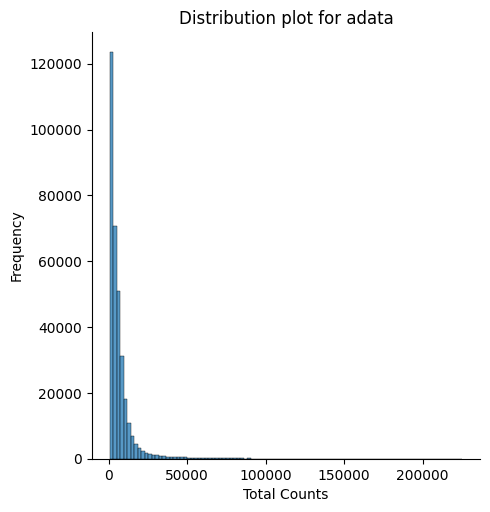

In [43]:
# Create a distribution plot for 'total_counts' column in the current AnnData frame
p = sns.displot(mdata.obs["total_counts"], bins=100, kde=False)
plt.title(f"Distribution plot for adata")  # Set plot title
plt.xlabel("Total Counts")  # Set x-axis label
plt.ylabel("Frequency")  # Set y-axis label
plt.show()  # Show the plot

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


<Axes: ylabel='value'>

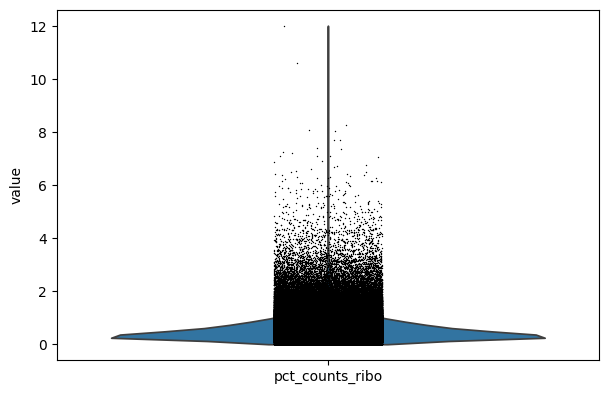

In [44]:
sc.pl.violin(mdata, keys="pct_counts_ribo", show=False)

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


<Axes: ylabel='value'>

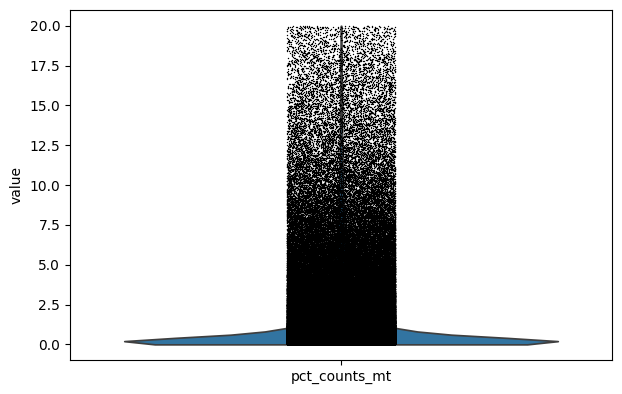

In [45]:
sc.pl.violin(mdata, keys="pct_counts_mt", show=False)

In [48]:
num_cells_above_50000 = (mdata.obs['pct_counts_mt'] > 10).sum()

print("Number of cells with mito% higher than 10:", num_cells_above_50000)


Number of cells with mito% higher than 10: 10498


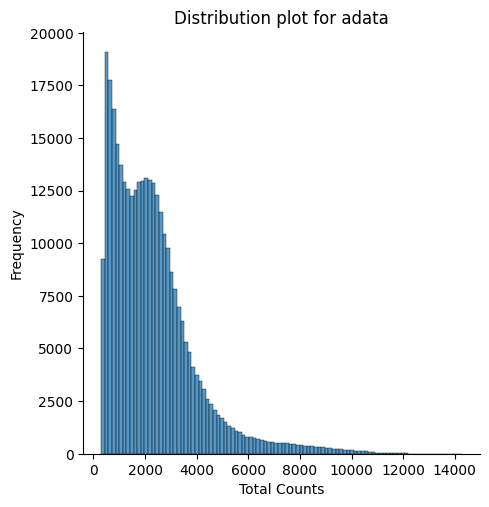

In [49]:
# Create a distribution plot for 'total_counts' column in the current AnnData frame
p = sns.displot(mdata.obs["n_genes_by_counts"], bins=100, kde=False)
plt.title(f"Distribution plot for adata")  # Set plot title
plt.xlabel("Total Counts")  # Set x-axis label
plt.ylabel("Frequency")  # Set y-axis label
plt.show()  # Show the plot

In [50]:
min_total_counts = mdata.obs['n_genes_by_counts'].min()
max_total_counts = mdata.obs['n_genes_by_counts'].max()

print("Minimum total counts:", min_total_counts)
print("Maximum total counts:", max_total_counts)

Minimum total counts: 300
Maximum total counts: 14277


In [51]:
num_cells_above_50000 = (mdata.obs['n_genes_by_counts'] > 10000).sum()

print("Number of cells with genes per cell counts higher than 10,000:", num_cells_above_50000)


Number of cells with genes per cell counts higher than 10,000: 1056


# filter max genes/cell and total counts (umi)

In [52]:
mdata

AnnData object with n_obs × n_vars = 335694 × 30936
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 's_score', 'g2m_score', 'phase', 'cell_cycle_diff', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'pct_counts_ribo', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'human_gene_id', 'n_cells', 'mouse_gene_id', 'mouse_gene_name', 'human_gene_name', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'counts', 'log1p_norm'

In [53]:
mdata_filtered = mdata[mdata.obs.pct_counts_mt < 10]

In [54]:
mdata_filtered

View of AnnData object with n_obs × n_vars = 325173 × 30936
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 's_score', 'g2m_score', 'phase', 'cell_cycle_diff', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'pct_counts_ribo', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'human_gene_id', 'n_cells', 'mouse_gene_id', 'mouse_gene_name', 'human_gene_name', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'counts', 'log1p_norm'

In [55]:
mdata_filtered = mdata_filtered[mdata_filtered.obs['n_genes_by_counts'] < 10000]
mdata_filtered

View of AnnData object with n_obs × n_vars = 324120 × 30936
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 's_score', 'g2m_score', 'phase', 'cell_cycle_diff', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'pct_counts_ribo', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'human_gene_id', 'n_cells', 'mouse_gene_id', 'mouse_gene_name', 'human_gene_name', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'counts', 'log1p_norm'

In [56]:
mdata_filtered = mdata_filtered[mdata_filtered.obs['total_counts'] < 50000]
mdata_filtered

View of AnnData object with n_obs × n_vars = 321566 × 30936
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 's_score', 'g2m_score', 'phase', 'cell_cycle_diff', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'pct_counts_ribo', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'human_gene_id', 'n_cells', 'mouse_gene_id', 'mouse_gene_name', 'human_gene_name', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'counts', 'log1p_norm'

In [57]:
sc.pp.filter_cells(mdata_filtered, min_counts=500)
mdata_filtered

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:137: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_counts'] = number


AnnData object with n_obs × n_vars = 321566 × 30936
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 's_score', 'g2m_score', 'phase', 'cell_cycle_diff', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'pct_counts_ribo', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system', 'n_counts'
    var: 'human_gene_id', 'n_cells', 'mouse_gene_id', 'mouse_gene_name', 'human_gene_name', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'counts', 'log1p_norm'

In [58]:
del mdata_filtered.layers["log1p_norm"]

In [59]:
sc.pp.filter_genes(mdata_filtered, min_cells=20)
mdata_filtered

AnnData object with n_obs × n_vars = 321566 × 29098
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 's_score', 'g2m_score', 'phase', 'cell_cycle_diff', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'pct_counts_ribo', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system', 'n_counts'
    var: 'human_gene_id', 'n_cells', 'mouse_gene_id', 'mouse_gene_name', 'human_gene_name', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'counts'

In [60]:
mdata_filtered=mdata_filtered[:,np.array((mdata_filtered.X>0).sum(axis=0)>20).ravel()]
mdata_filtered

View of AnnData object with n_obs × n_vars = 321566 × 29040
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 's_score', 'g2m_score', 'phase', 'cell_cycle_diff', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'pct_counts_ribo', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system', 'n_counts'
    var: 'human_gene_id', 'n_cells', 'mouse_gene_id', 'mouse_gene_name', 'human_gene_name', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'counts'

In [63]:
sc.pp.normalize_total(mdata_filtered, target_sum=1e4)
mdata_filtered.layers["log1p_norm"] = sc.pp.log1p(mdata_filtered.X)

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [65]:
mdata_filtered.write_h5ad('./sysVI/Macnair_QC_resetX_TRIMMED_BACKUP.h5ad')

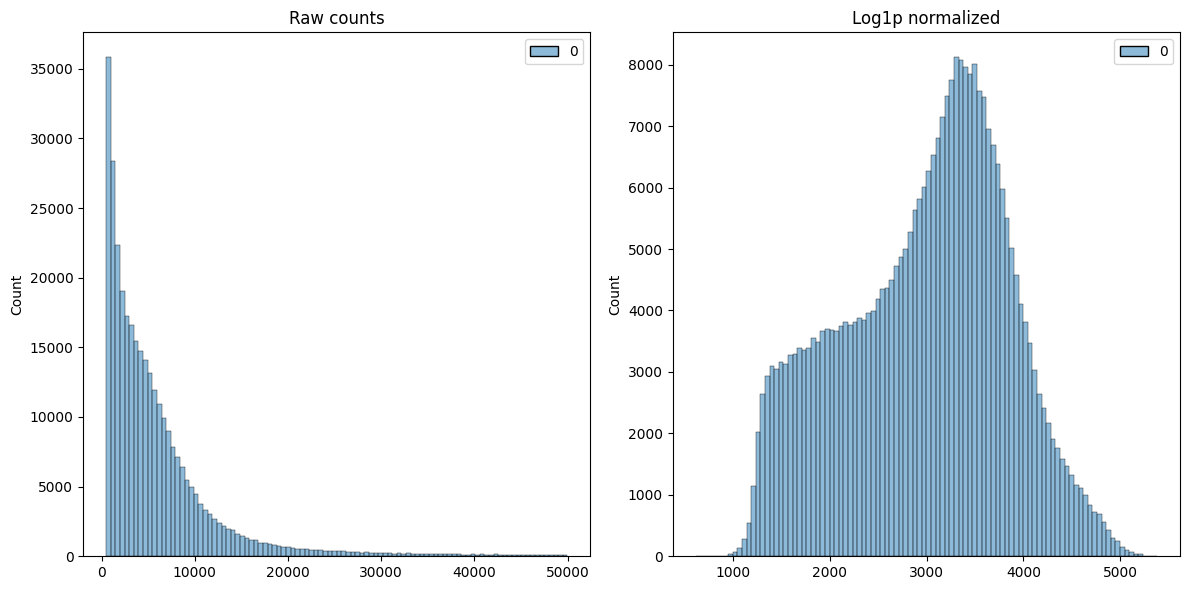

In [67]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot total counts
sns.histplot(mdata_filtered.layers["counts"].sum(1), bins=100, kde=False, ax=axes[0])
axes[0].set_title("Raw counts")

# Plot shifted logarithm
sns.histplot(mdata_filtered.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Log1p normalized")

plt.tight_layout()
plt.show()

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


<Axes: ylabel='value'>

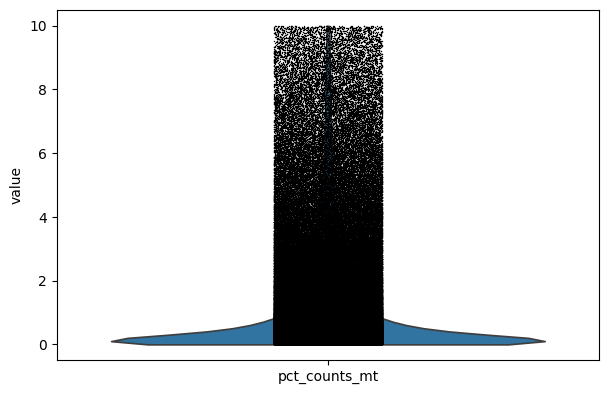

In [68]:
sc.pl.violin(mdata_filtered, keys="pct_counts_mt", show=False)

# Repeat for pandey and shen

In [117]:
pdata = sc.read_h5ad('./human_mouse/pdata_m2h_simplified_labeled.h5ad')
sdata = sc.read_h5ad('./human_mouse/sdata_m2h_simplified_labeled.h5ad')

In [118]:
pdata

AnnData object with n_obs × n_vars = 41938 × 23111
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'mouse_gene_id', 'n_cells', 'mouse_gene_name', 'human_gene_name', 'human_gene_id'
    layers: 'counts', 'log1p_norm'

In [119]:
sdata

AnnData object with n_obs × n_vars = 48734 × 21096
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'mouse_gene_id', 'n_cells', 'mouse_gene_name', 'human_gene_name', 'human_gene_id'
    layers: 'counts', 'log1p_norm'

# Pandey:

In [120]:
print(pdata.X[:5, :5])

  (0, 3)	0.18772413
  (0, 4)	0.18772413
  (1, 2)	0.48245856
  (3, 2)	0.35401866
  (4, 2)	0.61731994
  (4, 4)	0.193499


In [121]:
print(pdata.raw.X[:5, :5])

  (0, 4)	0.18772413
  (0, 3)	0.18772413
  (1, 2)	0.48245856
  (3, 2)	0.35401866
  (4, 4)	0.193499
  (4, 2)	0.61731994


In [122]:
print("Type of data in .raw attribute:", type(pdata.raw))

Type of data in .raw attribute: <class 'anndata._core.raw.Raw'>


In [123]:
print("Type of data in .X attribute:", type(pdata.X))

Type of data in .X attribute: <class 'scipy.sparse._csr.csr_matrix'>


In [124]:
pdata.X = pdata.layers['counts']
del pdata.layers["log1p_norm"]

In [125]:
print(pdata.X[:5, :5])

  (0, 4)	1
  (0, 3)	1
  (1, 2)	3
  (3, 2)	2
  (4, 4)	1
  (4, 2)	4


In [126]:
print(pdata.raw.X[:5, :5])

  (0, 4)	0.18772413
  (0, 3)	0.18772413
  (1, 2)	0.48245856
  (3, 2)	0.35401866
  (4, 4)	0.193499
  (4, 2)	0.61731994


In [127]:
del pdata.raw

In [129]:
pdata.raw = pdata

In [130]:
print(pdata.raw.X[:5, :5])

  (0, 4)	1
  (0, 3)	1
  (1, 2)	3
  (3, 2)	2
  (4, 4)	1
  (4, 2)	4


In [131]:
pdata.write_h5ad('./sysVI/Pandey_resetX_BACKUP.h5ad')

In [133]:
min_total_counts = pdata.obs['total_counts'].min()
max_total_counts = pdata.obs['total_counts'].max()

print("Minimum total counts:", min_total_counts)
print("Maximum total counts:", max_total_counts)

Minimum total counts: 507.0
Maximum total counts: 49829.0


In [134]:
min_total_counts = pdata.obs['n_genes_by_counts'].min()
max_total_counts = pdata.obs['n_genes_by_counts'].max()

print("Minimum n_genes_by_counts:", min_total_counts)
print("Maximum n_genes_by_counts:", max_total_counts)

Minimum n_genes_by_counts: 227.0
Maximum n_genes_by_counts: 7966.0


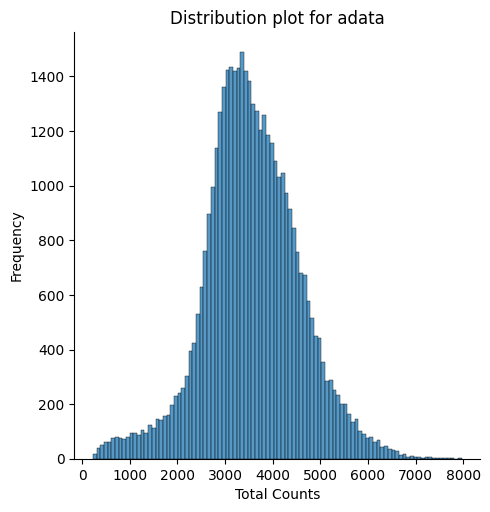

In [135]:
# Create a distribution plot for 'total_counts' column in the current AnnData frame
p = sns.displot(pdata.obs["n_genes_by_counts"], bins=100, kde=False)
plt.title(f"Distribution plot for adata")  # Set plot title
plt.xlabel("Total Counts")  # Set x-axis label
plt.ylabel("Frequency")  # Set y-axis label
plt.show()  # Show the plot

In [137]:
# Compute the average (mean) of n_genes_by_counts
average_n_genes_by_counts = adata.obs['n_genes_by_counts'].mean()

print("Average n_genes_by_counts:", average_n_genes_by_counts)

Average n_genes_by_counts: 1165.197298175572


In [136]:
# Compute the average (mean) of n_genes_by_counts
average_n_genes_by_counts = pdata.obs['n_genes_by_counts'].mean()

print("Average n_genes_by_counts:", average_n_genes_by_counts)

Average n_genes_by_counts: 3564.929944203348


/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


<Axes: ylabel='value'>

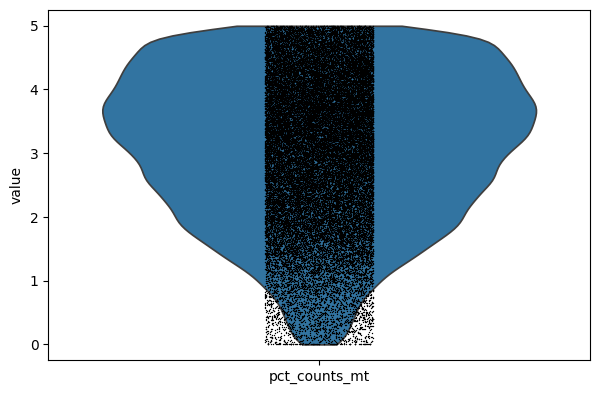

In [139]:
sc.pl.violin(pdata, keys="pct_counts_mt", show=False)

In [140]:
# Compute the average (mean) of n_genes_by_counts
average_n_genes_by_counts = adata.obs['pct_counts_mt'].mean()

print("Average pct_counts_mt:", average_n_genes_by_counts)

Average pct_counts_mt: 0.0474650660024704


In [141]:
# Compute the average (mean) of n_genes_by_counts
average_n_genes_by_counts = pdata.obs['pct_counts_mt'].mean()

print("Average pct_counts_mt:", average_n_genes_by_counts)

Average pct_counts_mt: 3.0747030421997894


In [142]:
pdata

AnnData object with n_obs × n_vars = 41938 × 23111
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'mouse_gene_id', 'n_cells', 'mouse_gene_name', 'human_gene_name', 'human_gene_id'
    layers: 'counts'

In [143]:
sc.pp.filter_genes(pdata, min_cells=10)
pdata

AnnData object with n_obs × n_vars = 41938 × 21464
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'mouse_gene_id', 'n_cells', 'mouse_gene_name', 'human_gene_name', 'human_gene_id'
    layers: 'counts'

In [144]:
pdata=pdata[:,np.array((pdata.X>0).sum(axis=0)>20).ravel()]
pdata

View of AnnData object with n_obs × n_vars = 41938 × 20384
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'mouse_gene_id', 'n_cells', 'mouse_gene_name', 'human_gene_name', 'human_gene_id'
    layers: 'counts'

In [145]:
print(pdata.X[:5, :5])

  (0, 3)	1
  (0, 4)	1
  (1, 2)	3
  (3, 2)	2
  (4, 2)	4
  (4, 4)	1


In [146]:
sc.pp.normalize_total(pdata, target_sum=1e4)
pdata.layers["log1p_norm"] = sc.pp.log1p(pdata.X)

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [147]:
print(pdata.X[:5, :5])

  (0, 3)	0.18772767
  (0, 4)	0.18772767
  (1, 2)	0.4824902
  (3, 2)	0.35401866
  (4, 2)	0.6173593
  (4, 4)	0.19351403


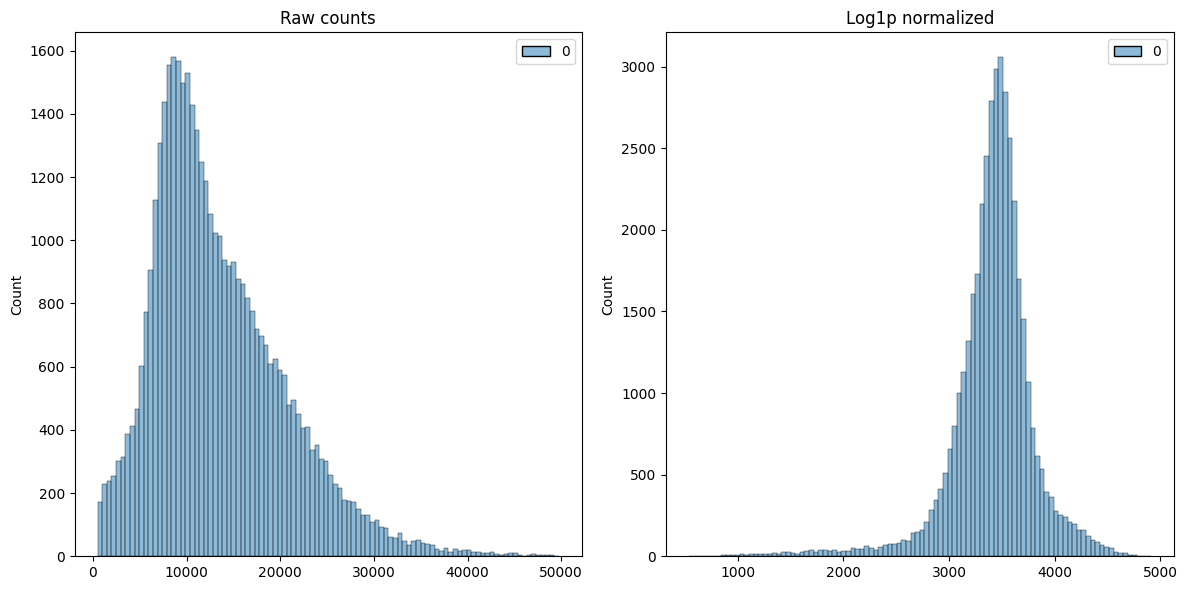

In [148]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot total counts
sns.histplot(pdata.layers["counts"].sum(1), bins=100, kde=False, ax=axes[0])
axes[0].set_title("Raw counts")

# Plot shifted logarithm
sns.histplot(pdata.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Log1p normalized")

plt.tight_layout()
plt.show()

In [149]:
pdata.write_h5ad('./sysVI/Pandey_QC_resetX_TRIMMED_BACKUP.h5ad')

In [150]:
pdata

AnnData object with n_obs × n_vars = 41938 × 20384
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'mouse_gene_id', 'n_cells', 'mouse_gene_name', 'human_gene_name', 'human_gene_id'
    layers: 'counts', 'log1p_norm'

# Cont for Shen

In [151]:
sdata

AnnData object with n_obs × n_vars = 48734 × 21096
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'mouse_gene_id', 'n_cells', 'mouse_gene_name', 'human_gene_name', 'human_gene_id'
    layers: 'counts', 'log1p_norm'

In [152]:
print(sdata.X[:5, :5])

  (1, 2)	1.3966963
  (2, 2)	1.010965


In [153]:
print(sdata.raw.X[:5, :5])

  (1, 2)	1.3966963
  (2, 2)	1.010965


In [154]:
print("Type of data in .raw attribute:", type(sdata.raw))

Type of data in .raw attribute: <class 'anndata._core.raw.Raw'>


In [155]:
print("Type of data in .X attribute:", type(sdata.X))

Type of data in .X attribute: <class 'scipy.sparse._csr.csr_matrix'>


In [156]:
sdata.X = sdata.layers['counts']
del sdata.layers["log1p_norm"]

In [163]:
print(sdata.X[:5, :5])

  (1, 2)	2
  (2, 2)	1


In [167]:
sdata.raw = sdata

In [168]:
print(sdata.raw.X[:5, :5])

  (1, 2)	2
  (2, 2)	1


In [169]:
print("Type of data in .X attribute:", type(sdata.X))

Type of data in .X attribute: <class 'scipy.sparse._csr.csr_matrix'>


In [170]:
print("Type of data in .raw attribute:", type(sdata.raw))

Type of data in .raw attribute: <class 'anndata._core.raw.Raw'>


In [171]:
sdata.write_h5ad('./sysVI/Shen_resetX_BACKUP.h5ad')

In [175]:
min_total_counts = sdata.obs['total_counts'].min()
max_total_counts = sdata.obs['total_counts'].max()

print("Minimum total counts:", min_total_counts)
print("Maximum total counts:", max_total_counts)

Minimum total counts: 500.0
Maximum total counts: 28942.0


In [176]:
min_total_counts = sdata.obs['n_genes_by_counts'].min()
max_total_counts = sdata.obs['n_genes_by_counts'].max()

print("Minimum n_genes_by_counts:", min_total_counts)
print("Maximum n_genes_by_counts:", max_total_counts)

Minimum n_genes_by_counts: 201.0
Maximum n_genes_by_counts: 5039.0


In [179]:
# Count the number of cells with total counts higher than 50,000
num_cells_above_50000 = (sdata.obs['total_counts'] > 20000).sum()

print("Number of cells with total counts higher than 20,000:", num_cells_above_50000)


Number of cells with total counts higher than 20,000: 38


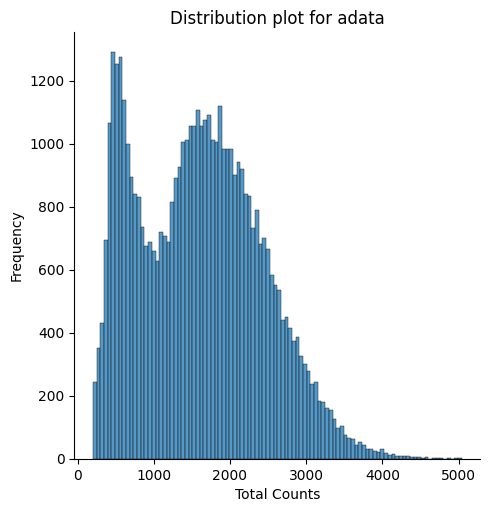

In [178]:
# Create a distribution plot for 'total_counts' column in the current AnnData frame
p = sns.displot(sdata.obs["n_genes_by_counts"], bins=100, kde=False)
plt.title(f"Distribution plot for adata")  # Set plot title
plt.xlabel("Total Counts")  # Set x-axis label
plt.ylabel("Frequency")  # Set y-axis label
plt.show()  # Show the plot

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


<Axes: ylabel='value'>

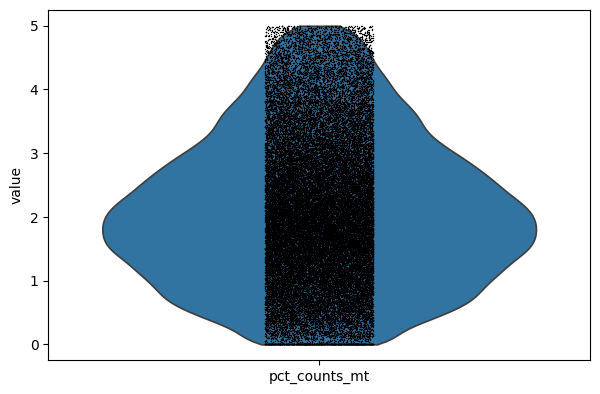

In [180]:
sc.pl.violin(sdata, keys="pct_counts_mt", show=False)

In [181]:
# Compute the average (mean) of n_genes_by_counts
average_n_genes_by_counts = sdata.obs['pct_counts_mt'].mean()

print("Average pct_counts_mt:", average_n_genes_by_counts)

Average pct_counts_mt: 2.1139832875207567


In [182]:
# Compute the average (mean) of n_genes_by_counts
average_n_genes_by_counts = mdata_filtered.obs['pct_counts_mt'].mean()

print("Average pct_counts_mt:", average_n_genes_by_counts)

Average pct_counts_mt: 1.2668583244789868


In [183]:
sdata

AnnData object with n_obs × n_vars = 48734 × 21096
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'mouse_gene_id', 'n_cells', 'mouse_gene_name', 'human_gene_name', 'human_gene_id'
    layers: 'counts'

In [184]:
sdata_filt = sdata[sdata.obs['total_counts'] < 20000]
sdata_filt

View of AnnData object with n_obs × n_vars = 48696 × 21096
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'mouse_gene_id', 'n_cells', 'mouse_gene_name', 'human_gene_name', 'human_gene_id'
    layers: 'counts'

In [185]:
sc.pp.filter_genes(sdata_filt, min_cells=10)
sdata_filt

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:250: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


AnnData object with n_obs × n_vars = 48696 × 19458
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'mouse_gene_id', 'n_cells', 'mouse_gene_name', 'human_gene_name', 'human_gene_id'
    layers: 'counts'

In [186]:
sdata_filt=sdata_filt[:,np.array((sdata_filt.X>0).sum(axis=0)>20).ravel()]
sdata_filt

View of AnnData object with n_obs × n_vars = 48696 × 18318
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'mouse_gene_id', 'n_cells', 'mouse_gene_name', 'human_gene_name', 'human_gene_id'
    layers: 'counts'

In [187]:
print(sdata_filt.X[:5, :5])

  (0, 4)	1
  (1, 1)	2
  (1, 4)	1
  (2, 1)	1
  (2, 4)	1


In [188]:
sc.pp.normalize_total(sdata_filt, target_sum=1e4)
sdata_filt.layers["log1p_norm"] = sc.pp.log1p(sdata_filt.X)
sdata_filt

/afs/crc.nd.edu/user/e/eaboelno/miniforge3/envs/sysVI/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


AnnData object with n_obs × n_vars = 48696 × 18318
    obs: 'sample_id', 'publication', 'sample_id_anon', 'individual_id_anon', 'replicate', 'treatment', 'condition', 'tissue', 'time', 'batch', 'lesion_type', 'sample_source', 'diagnosis', 'n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 's_score', 'g2m_score', 'phase', 'type_fine', 'type_broad', 'cluster_zoom', 'exclude_pseudobulk', 'seq_pool', 'sex', 'age_at_death', 'smoker', 'cause_of_death', 'years_w_ms', 'pmi_minutes', 'age_scale', 'age_cat', 'pmi_cat', 'pmi_cat2', 'cell_cycle_diff', 'cell_type_eval', 'library_type', 'sample_type', 'organism', 'system'
    var: 'mouse_gene_id', 'n_cells', 'mouse_gene_name', 'human_gene_name', 'human_gene_id'
    layers: 'counts', 'log1p_norm'

In [189]:
print(sdata_filt.X[:5, :5])

  (0, 4)	0.93436444
  (1, 1)	1.3971543
  (1, 4)	0.92498815
  (2, 1)	1.0110762
  (2, 4)	1.0110762


In [190]:
min_total_counts = sdata_filt.obs['total_counts'].min()
max_total_counts = sdata_filt.obs['total_counts'].max()

print("Minimum total counts:", min_total_counts)
print("Maximum total counts:", max_total_counts)

Minimum total counts: 500.0
Maximum total counts: 19990.0


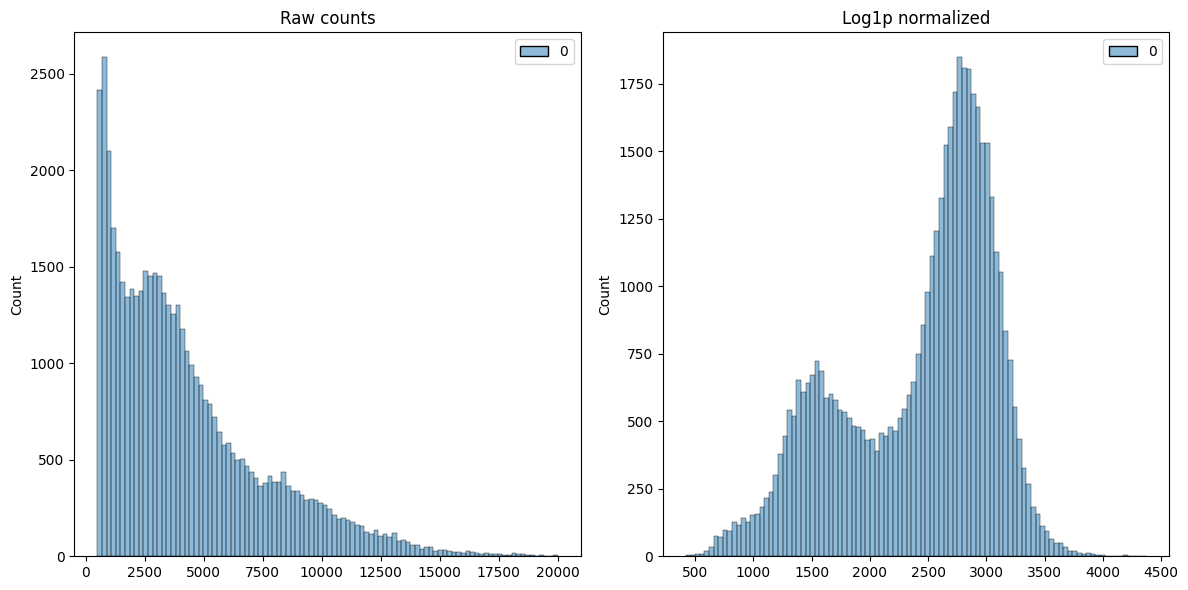

In [191]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot total counts
sns.histplot(sdata_filt.layers["counts"].sum(1), bins=100, kde=False, ax=axes[0])
axes[0].set_title("Raw counts")

# Plot shifted logarithm
sns.histplot(sdata_filt.layers["log1p_norm"].sum(1), bins=100, kde=False, ax=axes[1])
axes[1].set_title("Log1p normalized")

plt.tight_layout()
plt.show()

In [192]:
sdata_filt.write_h5ad('./sysVI/Shen_QC_resetX_TRIMMED_BACKUP.h5ad')